In [1]:
import gymnasium as gym
import miniworld
from matplotlib import pyplot as plt

miniworld_env_ids = [env_id for env_id in gym.registry if "MiniWorld" in env_id]

2025-06-09 14:16:32.571 Python[50530:2994742] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/zz/_8nvyjvj4jd9v1rfts46s0ph0000gn/T/com.apple.python3.savedState


In [2]:
print(miniworld_env_ids)

['MiniWorld-CollectHealth-v0', 'MiniWorld-FourRooms-v0', 'MiniWorld-Hallway-v0', 'MiniWorld-Maze-v0', 'MiniWorld-MazeS2-v0', 'MiniWorld-MazeS3-v0', 'MiniWorld-MazeS3Fast-v0', 'MiniWorld-OneRoom-v0', 'MiniWorld-OneRoomS6-v0', 'MiniWorld-OneRoomS6Fast-v0', 'MiniWorld-PickupObjects-v0', 'MiniWorld-PutNext-v0', 'MiniWorld-RoomObjects-v0', 'MiniWorld-Sidewalk-v0', 'MiniWorld-Sign-v0', 'MiniWorld-TMaze-v0', 'MiniWorld-TMazeLeft-v0', 'MiniWorld-TMazeRight-v0', 'MiniWorld-ThreeRooms-v0', 'MiniWorld-WallGap-v0', 'MiniWorld-YMaze-v0', 'MiniWorld-YMazeLeft-v0', 'MiniWorld-YMazeRight-v0']


In [3]:
def make_env():
    env = gym.make("MiniWorld-Maze-v0")
    return env

In [4]:
"""
The observation space is an `ndarray` with shape `(obs_height, obs_width, 3)`
representing an RGB image of what the agents see.
"""

"""
class Actions(IntEnum):
      # Turn left or right by a small amount
      turn_left = 0
      turn_right = 1

      # Move forward or back by a small amount
      move_forward = 2
      move_back = 3

      # Pick up or drop an object being carried
      pickup = 4
      drop = 5

      # Toggle/activate an object
      toggle = 6

      # Done completing task
      done = 7
"""

env = make_env()

Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


Discrete(3)
Box(0, 255, (60, 80, 3), uint8)
{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30, 'render_modes': ['human', 'rgb_array'], 'render_fps': 30}
this is obv
[[[ 69  51  45]
  [ 68  51  45]
  [ 67  50  44]
  ...
  [104 104 104]
  [105 105 105]
  [106 106 107]]

 [[ 69  51  45]
  [ 68  51  45]
  [ 69  51  45]
  ...
  [106 106 106]
  [106 106 106]
  [106 106 106]]

 [[ 69  54  47]
  [ 68  51  45]
  [ 70  52  46]
  ...
  [103 103 103]
  [104 104 104]
  [105 105 105]]

 ...

 [[ 80  59  50]
  [ 83  70  62]
  [ 85  73  65]
  ...
  [143 141 137]
  [ 97  96  93]
  [112 111 108]]

 [[ 80  57  48]
  [ 83  69  61]
  [ 84  71  63]
  ...
  [153 151 147]
  [ 89  88  85]
  [ 50  49  47]]

 [[ 79  56  47]
  [ 82  68  60]
  [ 82  70  62]
  ...
  [102 100  97]
  [155 153 148]
  [146 144 140]]]
{}
0.0
25.75
0.0
25.75


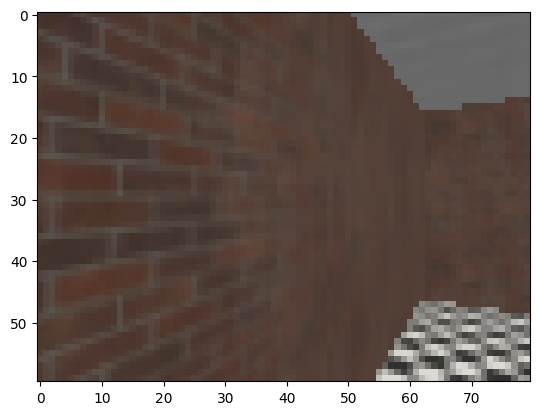

In [5]:
print(env.action_space)
print(env.observation_space)
print(env.metadata)
obs, info = env.reset()
print("this is obv")
print(obs)
print(info)

print(env.get_wrapper_attr('min_x'))
print(env.get_wrapper_attr('max_x'))
print(env.get_wrapper_attr('min_z'))
print(env.get_wrapper_attr('max_z'))
plt.imshow(obs)

[24.97198234  0.         17.4356174 ]
-1.2692318523435382


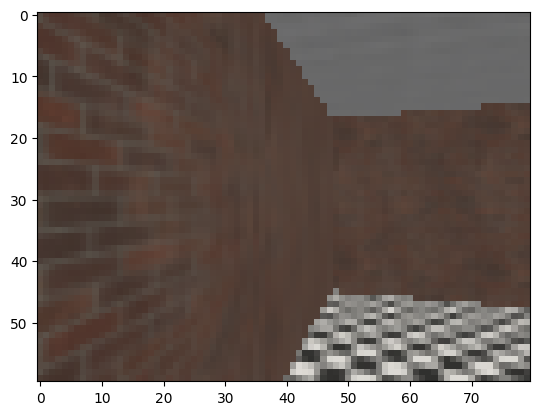

In [6]:
# Turn left or right by a small amount
turn_left = 0
turn_right = 1

# Move forward or back by a small amount
move_forward = 2
move_back = 3

# Pick up or drop an object being carried
pickup = 4
drop = 5

# Toggle/activate an object
toggle = 6

# Done completing task
done = 7

obs, reward, terminated, truncated, info = env.step(1)
print(env.get_wrapper_attr('agent').pos)
print(env.get_wrapper_attr('agent').dir)
plt.imshow(obs)


In [7]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing, IdentitySmoothing
import miniworld
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch

### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
shapes = [(3, 3, 4), (4, 4, 5)]


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    env = gym.make("MiniWorld-Maze-v0", max_episode_steps=-1, params=params, domain_rand=False)
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
model = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)


#### agent
agent = MiniworldVectorhashAgent(model, env)

ModuleNotFoundError: No module named 'pretrainedmodels'

In [2]:
print(limits)

tensor([25.7500, 25.7500,  6.2832])


In [3]:
path = [0] * 18 + [3] * 10

In [4]:
import torch
from agent import path_test

results = path_test(agent, path, limits=torch.tensor([1, 1, 2 * math.pi / 8]))

info for each h directly after learning it
h max, min, mean tensor(6.0894, device='mps:0') tensor(0., device='mps:0') tensor(1.7384, device='mps:0')
h_from_s max, min, mean tensor(6.0875, device='mps:0') tensor(0., device='mps:0') tensor(1.7379, device='mps:0')
h_from_s_denoised max, min, mean tensor(2.2593, device='mps:0') tensor(0.9753, device='mps:0') tensor(1.7270, device='mps:0')
avg nonzero/greaterzero h from book: tensor(536, device='mps:0') tensor(536, device='mps:0')
avg nonzero/greaterzero h from s: tensor(536, device='mps:0') tensor(536, device='mps:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='mps:0') tensor(600, device='mps:0')
mse/cosinesimilarity h from book and h from s tensor(4.4076e-07, device='mps:0') tensor([1.], device='mps:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.4481, device='mps:0') tensor([0.8254], device='mps:0')
mse/cosinesimilarity s and s from h from s tensor(5.9175e-13, device='mps:0') tensor([1.], device='mp

/Users/awalnoorsinghbajaj/Desktop/rl-research/vectorhash/vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/Users/awalnoorsinghbajaj/Desktop/rl-research/vectorhash/vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/Users/awalnoorsinghbajaj/Desktop/rl-research/vectorhash/vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse

new positions: tensor([25.7500, 25.7500,  0.2942], device='mps:0')
new positions: tensor([25.7500, 25.7500,  0.5875], device='mps:0')
new positions: tensor([25.7500, 25.7500,  0.8790], device='mps:0')
new positions: tensor([25.7500, 25.7500,  1.1700], device='mps:0')
new positions: tensor([25.7500, 25.7500,  1.4626], device='mps:0')
new positions: tensor([25.7500, 25.7500,  1.7561], device='mps:0')
new positions: tensor([25.7500, 25.7500,  2.0501], device='mps:0')
new positions: tensor([25.7500, 25.7500,  2.3441], device='mps:0')
new positions: tensor([25.7500, 25.7500,  2.6382], device='mps:0')
new positions: tensor([25.7500, 25.7500,  2.9322], device='mps:0')
new positions: tensor([25.7500, 25.7500,  3.2262], device='mps:0')
new positions: tensor([25.7500, 25.7500,  3.5202], device='mps:0')
new positions: tensor([25.7500, 25.7500,  3.8143], device='mps:0')
new positions: tensor([25.7500, 25.7500,  4.1083], device='mps:0')
new positions: tensor([25.7500, 25.7500,  4.4023], device='mps

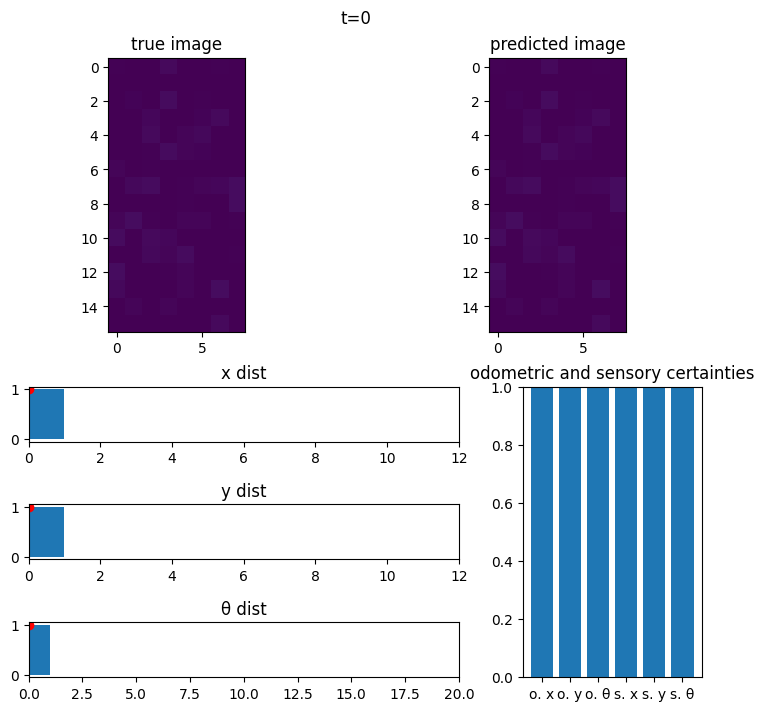

In [5]:
history = results[1]
ani = history.make_image_video()

In [6]:
ani.save("gifs/testpath4.gif", progress_callback=lambda current, total: print(f"frame {current}/{total}"), dpi=150)

MovieWriter ffmpeg unavailable; using Pillow instead.


frame 0/28
frame 1/28
frame 2/28
frame 3/28
frame 4/28
frame 5/28
frame 6/28
frame 7/28
frame 8/28
frame 9/28
frame 10/28
frame 11/28
frame 12/28
frame 13/28
frame 14/28
frame 15/28
frame 16/28
frame 17/28
frame 18/28
frame 19/28
frame 20/28
frame 21/28
frame 22/28
frame 23/28
frame 24/28
frame 25/28
frame 26/28
frame 27/28
